In [1]:
import copy
import os
import sys
sys.path.append("/home/diego/python/auditory-cortex/data/") 
sys.path.append("/home/diego/python/utils/") 

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import torch
from torch.optim import Adam
# import seaborn as sns

from gglm.glm.base import GLM
from gglm.glm.torchglm import TorchGLM
from gglm.glm.mmdglm import MMDGLM
# from gglm.cnncritic import MMDCritic
from sptr.sptr import SpikeTrain
from gglm.utils import shift_array
from kernel.fun import KernelFun
from kernel.rect import KernelRect

from celldata import CellData

import myplt

%load_ext autoreload
%autoreload 2

In [2]:
# path = '/home/diego/Dropbox/projects/auditory-cortex/data/ACx_data_2/ACxCalyx/20190918-xxx999-001-004/'
# path = '/home/diego/Dropbox/projects/auditory-cortex/data/ACx_data_2/ACxCalyx/'
path = '/home/diego/Dropbox/projects/auditory-cortex/data/ACx_data_2/ACxThelo/'
l = os.listdir(path)
cd = CellData(path + l[2])

# thelo 0, 2!

In [3]:
cd.df['next'] = np.append(cd.df.trigger.diff().values[1:], np.nan)

In [4]:
palette = dict(dc='dodgerblue', fr_ml='k', fr_mmd='C3')
# palette = dict(dc='k', fr_ml='dodgerblue', fr_mmd='C4')

In [22]:
def distance(r_dc, mask_spikes, r_fr, mask_spikes_fr):
#     r_te, r_fr = r[:, y == 1], r[:, y == 0]
    r_dc, r_fr = r_dc / r_dc.shape[0], r_fr / r_fr.shape[0]
    n_batch_dc, n_batch_fr = r_dc.shape[1], r_fr.shape[1]
    r_sum_dc, r_sum_fr = torch.sum(r_dc, 1), torch.sum(r_fr, 1)
        
    norm2_dc = (torch.sum(r_sum_dc**2) - torch.sum(r_dc**2)) / (n_batch_dc * (n_batch_dc - 1))
    norm2_fr = (torch.sum(r_sum_fr**2) - torch.sum(r_fr**2)) / (n_batch_fr * (n_batch_fr - 1))
    mean_dot = torch.sum(r_sum_dc * r_sum_fr, 0) / (n_batch_dc * n_batch_fr)
    d = (norm2_dc + norm2_fr - 2 * mean_dot)
    return d

lam_mmd = 1e0 # isi_mean
def kerneln_npsk(t, mask_spikes1, mask_spikes2):
    n_spk1 = torch.sum(mask_spikes1, 0).double()
    n_spk2 = torch.sum(mask_spikes2, 0).double()
    gramian = n_spk1[:, None] * n_spk2[None, :]
#     gramian = torch.from_numpy(gramian)
    return gramian
phi, kernel = None, kerneln_npsk

def fun_metrics_ml(self, t, mask_spikes, X):
    n_batch_fr = 100
    T = st_val.t[-1] - st_val.t[0] + st_val.t[1]
    _, r_dc = self.sample_conditioned(st_val.t, st_val.mask)
    u_fr, r_fr, mask_spikes_fr = self.sample(st_val.t, shape=(n_batch_fr,))
    mmd = kerneln_npsk(st_val.t, mask_spikes, mask_spikes_fr)
    fr = np.mean(np.sum(mask_spikes_fr, 0) / T * 1000)
    return dict(fr=fr, mmd=mmd)

def fun_metrics_mmd(self, t, mask_spikes, X, n_batch_fr):
    T = st_val.t[-1] - st_val.t[0] + st_val.t[1]
    _, r_dc = self.sample_conditioned(st_val.t, st_val.mask)
    u_fr, r_fr, mask_spikes_fr = self.sample(st_val.t, shape=(n_batch_fr,))
#     mmd = distance(torch.from_numpy(r_dc), st_val.mask, torch.from_numpy(r_fr), mask_spikes_fr)
    mask_spikes_fr = torch.from_numpy(mask_spikes_fr)
    mmd = kerneln_npsk(st_val.t, mask_spikes, mask_spikes_fr)
    u_fr, r_fr, mask_spikes_fr = self.sample(st_val.t, shape=(n_batch_fr,))
    fr = np.mean(np.sum(mask_spikes_fr, 0) / T * 1000)
    return dict(fr=fr, mmd=mmd)

In [6]:
np.random.seed(2)

dic_filter = {'type': 'tone'}
t0, tf = -300, 400
t0_val, tf_val = -300, 1800

arg0, argf = int(t0 / cd.dt), int(tf / cd.dt)
t = np.arange(0, argf - arg0, 1) * cd.dt

cd.df = cd.df.iloc[:511]
mask_spikes = cd.get_mask_spikes_trials(dic_filter, t0=t0, tf=tf)
st_train = SpikeTrain(t, mask_spikes).subsample(1)

arg0, argf = int(t0_val / cd.dt), int(tf_val / cd.dt)
t = np.arange(0, argf - arg0, 1) * cd.dt
mask_spikes_val = cd.get_mask_spikes_trials({'type': 'fmsweep'}, t0=t0_val, tf=tf_val)
st_val = SpikeTrain(t, mask_spikes_val).subsample(1)

T = st_val.t[-1] - st_val.t[0] + st_val.t[1]
fr_data = np.mean(np.sum(st_val.mask, 0) / T * 1000)

tbins = [0, 4, 8, 16, 32, 64, 128, 256, 512]
eta = KernelRect(tbins=tbins, coefs=np.zeros(len(tbins) - 1))
eta.coefs = np.array([-1.6,  0.7,  0.8,  0.5, -0.1, -0.3 , -0.7, -1])
# eta = KernelFun.exponential([2, 100], coefs=[0, 0])

num_epochs = 200
n_batch_fr = 100
# num_epochs = 5
# n_batch_fr = 5
# lam_mmd = 1e0
# lr = 5e-2

### ML

In [7]:
# TorchGLM.metrics = fun_metrics_ml

lam_mmd = 1e0
lr = 1e-1
num_epochs = 150

glm = TorchGLM(u0=-4, eta=eta.copy())
# glm.metrics = fun_metrics_ml
optim = Adam(glm.parameters(), lr=lr)
loss_ml, metrics_ml = glm.train(st_train.t, st_train.mask, optim=optim, num_epochs=num_epochs, verbose=True, metrics=fun_metrics_ml)

_, r_val_dc_ml = glm.sample_conditioned(st_val.t, st_val.mask)
r_val_dc_ml = np.mean(r_val_dc_ml, 1)
_, r_fr_ml, mask_spikes_fr_ml = glm.sample(st_val.t, shape=(st_val.mask.shape[1],))
# st_fr_ml = SpikeTrain(st_val.t, mask_spikes_fr_ml[:, np.random.choice(n_batch_fr, size=)])
st_fr_ml = SpikeTrain(st_val.t, mask_spikes_fr_ml)
mean_r_fr_ml = np.mean(r_fr_ml, 1)
sum_r_fr_ml = np.sum(r_fr_ml, 1)

 epoch 149 of 150 nll 3028.6064

### MMD

In [34]:
lr, num_epochs = 1e-1, 20
n_batch_fr = 100

lr = torch.ones(num_epochs) * 1e-3

mask_spikes_train_torch = torch.from_numpy(st_train.mask).double()

# mmdglm = MMDGLM(u0=-4, eta=eta.copy())
mmdglm = MMDGLM(u0=glm.u0, eta=glm.eta.copy())
# mmdglm.metrics = fun_metrics_ml
# optim = Adam(mmdglm.parameters(), lr=lr)
loss_mmd, mmd, metrics_mmd = mmdglm.train(st_train.t, mask_spikes_train_torch, phi=None, kernel=kernel, lr=lr, lam_mmd=lam_mmd, 
                                          num_epochs=num_epochs, verbose=True, n_batch_fr=n_batch_fr, metrics=fun_metrics_mmd)
loss_mmd, mmd = np.array(loss_mmd), np.array(mmd)

_, r_val_dc_mmd = mmdglm.sample_conditioned(st_val.t, st_val.mask)
r_val_dc_mmd = np.mean(r_val_dc_mmd, 1)
_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(st_val.mask.shape[1],))
st_fr_mmd = SpikeTrain(st_val.t, mask_spikes_fr_mmd)
# mean_r_fr_mmd = np.mean(r_fr_mmd, 1)

 epoch 19 of 20 loss 6.3908386307

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


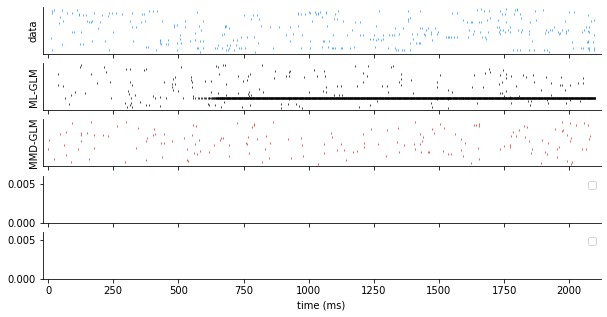

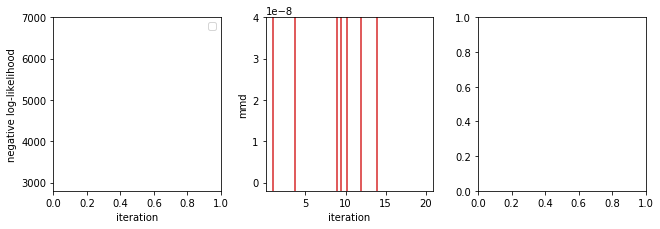

In [41]:
marker, ms, mew, lw = '|', 1.8, 0.7, 1
def plot_results():
    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(figsize=(10, 5), nrows=5, sharex=True)
    st_val.plot(ax=ax0, marker=marker, ms=ms, mew=mew, color=palette['dc'])
    st_fr_ml.plot(ax=ax1, marker=marker, ms=ms, mew=mew, color=palette['fr_ml'])
    st_fr_mmd.plot(ax=ax2, marker=marker, ms=ms, mew=mew, color=palette['fr_mmd'])
#     myplt.set_scale_bars(ax0), myplt.set_scale_bars(ax1), myplt.set_scale_bars(ax2)
    ax0.set_ylabel('data')
    ax0.set_yticks([])
    ax0.spines['right'].set_visible(False); ax0.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False); ax1.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False); ax2.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False); ax3.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False); ax4.spines['top'].set_visible(False)
    ax0.tick_params()
    ax1.set_ylabel('ML-GLM')
    ax1.set_yticks([])
    ax2.set_ylabel('MMD-GLM')
    ax2.set_yticks([])
#     ax3.plot(st_val.t, r_val_dc_ml, lw=lw, color=palette['dc'], label='conditioned')
#     ax3.plot(st_val.t, mean_r_fr_ml, lw=lw, color=palette['fr_ml'], label='free running')
    ax3.set_ylim(0, 6e-3)
    ax3.legend()
#     ax4.plot(st_val.t, r_val_dc_mmd, lw=lw, color=palette['dc'], label='conditioned')
#     ax4.plot(st_val.t, mean_r_fr_mmd, lw=lw, color=palette['fr_mmd'], label='free running')
    ax4.set_ylim(0, 6e-3)
    ax4.set_xlabel('time (ms)')
    ax4.legend()
#     myplt.set_scale_bars(ax3)
#     myplt.set_scale_bars(ax0)
    fig.savefig('/home/diego/Dropbox/generative_glm/figures/diverging_fr_acx1.pdf', transparent=True, bbox_inches='tight')
    
    fig, (ax4, ax5, ax6) = plt.subplots(figsize=(9, 3), ncols=3)
    fig.tight_layout()
    
    iteration = np.arange(1, num_epochs + 1, 1)
#     ax4.plot(iteration, loss_ml, label='ML-GLM', color=palette['fr_ml'])
#     ax4.plot(iteration, loss_mmd - mmd, label='MMD-GLM', color=palette['fr_mmd'])
    ax4.set_ylabel('negative log-likelihood')
    ax4.set_xlabel('iteration')
    ax4.set_ylim(2.8e3, 7e3)
    ax4.legend()
    
#     ax5.plot(iteration, metrics_ml['mmd'], label='ML-GLM', color=palette['fr_ml'])
#     ax5.plot(iteration, metrics_mmd['mmd'], label='MMD-GLM', color=palette['fr_mmd'])
    ax5.plot(iteration, mmd, label='MMD-GLM', color=palette['fr_mmd'])
    ax5.set_xlabel('iteration')
    ax5.set_ylabel('mmd')
    ax5.set_ylim(-2e-9, 4e-8)
    
#     ax6.plot(iteration, metrics_ml['fr'], label='ML-GLM', color=palette['fr_ml'])
#     ax6.plot(iteration, metrics_mmd['fr'], label='MMD-GLM', color=palette['fr_mmd'])
#     ax6.plot([1, num_epochs], [fr_data, fr_data], 'k--', label='data')
#     ax6.set_ylabel('firing rate (Hz)')
#     ax6.set_xlabel('iteration')
#     ax6.set_ylim(0, 12)
    fig.savefig('/home/diego/Dropbox/generative_glm/figures/diverging_fr_acx2.pdf', transparent=True, bbox_inches='tight')
    
plot_results()
#     fig, ax = plt.subplots(figsize=(3, 3))
# print(glm.u0)
# glm.eta.plot(ax=ax, offset=glm.u0)

In [39]:
metrics_mmd['mmd']

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [8., 6., 4.,  ..., 0., 4., 4.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [4., 3., 2.,  ..., 0., 2., 2.],
         [8., 6., 4.,  ..., 0., 4., 4.]], dtype=torch.float64),
 tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [10.,  4.,  8.,  ...,  2.,  2.,  4.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 5.,  2.,  4.,  ...,  1.,  1.,  2.],
         [10.,  4.,  8.,  ...,  2.,  2.,  4.]], dtype=torch.float64),
 tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 2., 14.,  4.,  ..., 12.,  4.,  2.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 1.,  7.,  2.,  ...,  6.,  2.,  1.],
         [ 2., 14.,  4.,  ..., 12.,  4.,  2.]], dtype=torch.float64),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [2., 0., 2.,  ..., 0., 2., 0.

-6.874234018903157 -6.341258875193035


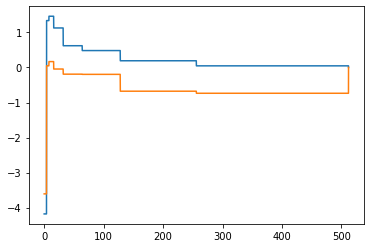

In [98]:
print(glm.u0, mmdglm.u0)
fig, ax = plt.subplots()
glm.eta.plot(ax=ax)
mmdglm.eta.plot(ax=ax)

Starting gradient ascent... 

 Iteration 42 of 200 | Elapsed time: 3.84 seconds | objective=-3035.66
 
 Iteration 42 of 200 | Converged | Elapsed time: 0.0639 minutes | Log posterior is monotonic 

 epoch 1 of 150 loss 7191.3654

/home/diego/anaconda3/envs/generative-glm/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/diego/anaconda3/envs/generative-glm/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 epoch 149 of 150 loss 3038.5943

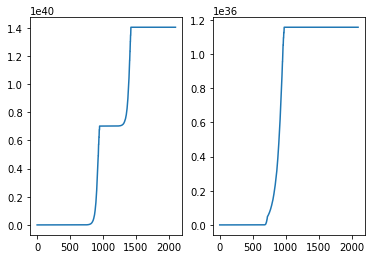

In [9]:
tbins = [0, 4, 8, 16, 32, 64, 128, 256, 512]
eta = KernelRect(tbins=tbins, coefs=np.zeros(len(tbins) - 1))
# eta = KernelFun.exponential([2, 100], coefs=[-1, 1])
glm = GLM(u0=-4, eta=eta.copy())
opt = glm.fit(st_dc.t, st_dc.mask, verbose=True)

n_batch_fr = 100

_, r_val_dc_ml = glm.sample_conditioned(st_val.t, st_val.mask)
r_val_dc_ml = np.mean(r_val_dc_ml, 1)
_, r_fr_ml, mask_spikes_fr_ml = glm.sample(st_val.t, shape=(n_batch_fr,))
# st_fr_ml = SpikeTrain(st_val.t, mask_spikes_fr_ml[:, np.random.choice(n_batch_fr, size=)])
st_fr_ml = SpikeTrain(st_val.t, mask_spikes_fr_ml)
mean_r_fr_ml = np.mean(r_fr_ml, 1)
sum_r_fr_ml = np.sum(r_fr_ml, 1)

glm2 = TorchGLM(u0=-4, eta=eta.copy())
optim = Adam(glm2.parameters(), lr=lr)
loss_ml, metrics_ml = glm2.train(st_dc.t, st_dc.mask, optim=optim, num_epochs=150, verbose=True, n_batch_fr=0)

_, r_val_dc_ml = glm2.sample_conditioned(st_val.t, st_val.mask)
r_val_dc_ml = np.mean(r_val_dc_ml, 1)
_, r_fr_ml, mask_spikes_fr_ml = glm2.sample(st_val.t, shape=(n_batch_fr,))
# st_fr_ml = SpikeTrain(st_val.t, mask_spikes_fr_ml[:, np.random.choice(n_batch_fr, size=)])
st_fr_ml = SpikeTrain(st_val.t, mask_spikes_fr_ml)
mean_r_fr_ml2 = np.mean(r_fr_ml, 1)
sum_r_fr_ml = np.sum(r_fr_ml, 1)

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.plot(mean_r_fr_ml)
ax2.plot(mean_r_fr_ml2)
# plt.plot(mean_r_fr_ml2)

fig, (ax1, ax2) = plt.subplots(ncols=2)
glm.eta.plot(ax=ax1)
glm2.eta.plot(ax=ax1)
ax2.plot(loss_ml)
ax2.plot(-opt.obj_iterations)

In [11]:
_, r_val_dc_ml = glm.sample_conditioned(st_val.t, st_val.mask)
r_val_dc_ml = np.mean(r_val_dc_ml, 1)
_, r_fr_ml, mask_spikes_fr_ml = glm.sample(st_val.t, shape=(n_batch_fr,))
st_fr_ml = SpikeTrain(st_val.t, mask_spikes_fr_ml)
mean_r_fr_ml = np.mean(r_fr_ml, 1)
sum_r_fr_ml = np.sum(r_fr_ml, 1)

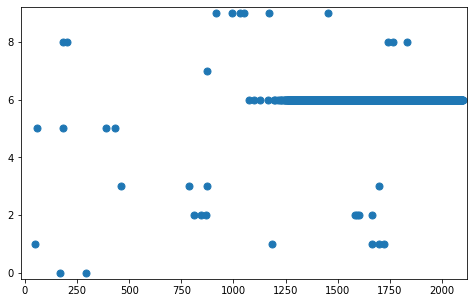

In [10]:
st_fr_ml.plot()

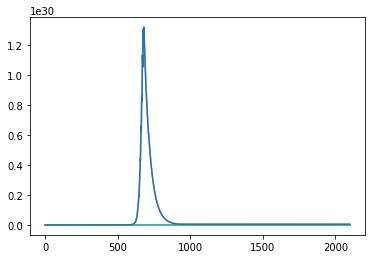

In [14]:
plt.figure()
plt.plot(st_val.t, r_fr_ml)
plt.plot(st_val.t, sum_r_fr_ml)

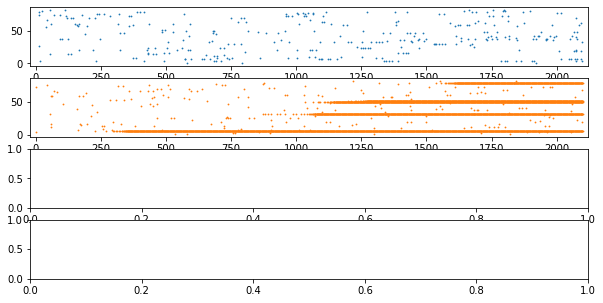

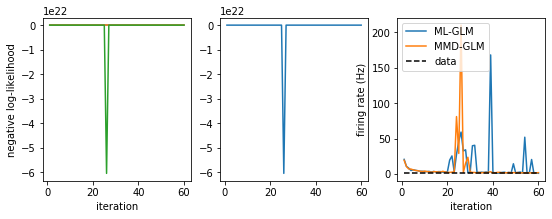

In [11]:
def plot_results():
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize=(10, 5), nrows=4)
#     fig = plt.figure(figsize=(10, 5))
#     r_row, r_col = [1, 1, 1, 1, 2, 2], [8, 8, 8, 8, 2, 2]
#     n_row, n_col = sum(r_row), sum(r_col)
#     axs = []
#     ax0 = plt.subplot2grid((n_row, n_col), (0, 0), rowspan=r_row[0], colspan=r_col[0])
#         rr += r_row[ii]
#         rc += r_col[ii]
    st_val.plot(ax=ax0, ms=0.8)
    st_fr.plot(ax=ax1, ms=0.8, color='C1')
    
    fig, (ax4, ax5, ax6) = plt.subplots(figsize=(9, 3), ncols=3)
    
    iteration = np.arange(1, num_epochs + 1, 1)
    ax4.plot(iteration, loss_ml, label='ML-GLM')
    ax4.plot(iteration, loss_mmd - mmd, label='MMD-GLM')
    ax4.set_ylabel('negative log-likelihood')
    ax4.set_xlabel('iteration')
    ax4.plot(iteration, mmd, label='MMD-GLM')
    ax5.plot(iteration, mmd, label='MMD-GLM')
    ax6.plot(iteration, metrics_ml['fr'], label='ML-GLM')
    ax6.plot(iteration, metrics_mmd['fr'], label='MMD-GLM')
    ax6.plot([1, num_epochs], [fr_data, fr_data], 'k--', label='data')
    ax6.set_ylabel('firing rate (Hz)')
    ax6.set_xlabel('iteration')
    ax6.legend()
    
plot_results()
#     fig, ax = plt.subplots(figsize=(3, 3))
# print(glm.u0)
# glm.eta.plot(ax=ax, offset=glm.u0)

In [7]:
u, r, mask_spikes_fr = glm.sample(st_te.t, shape=(mask_spikes.shape[1],))

(700, 428)

In [26]:
# cd.df[cd.df.type == 'fmsweep']
a = int(np.round(cd.df.trigger.diff().min() / 2)) - 1

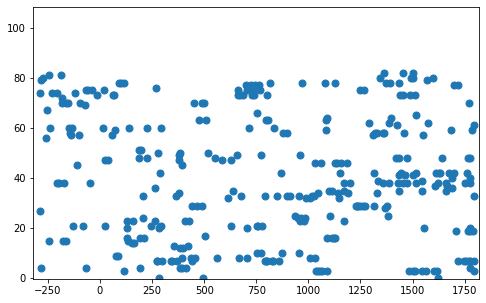

In [63]:
st_te.plot()

(array([547.,  58.,  53.,  13.,  12.,   0.,   2.,   0.,   1.,   1.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 10 Patch objects>)

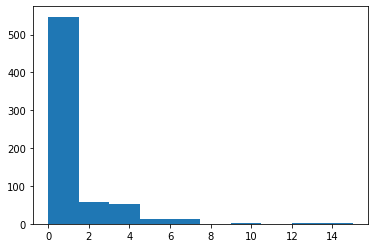

In [164]:
np.mean(np.sum(mask_spikes, 0)), np.mean(np.sum(mask_spikes_fr, 0))
plt.hist(np.sum(mask_spikes, 0), bins=)

In [165]:
0.99**100, 0.99**2

(0.3660323412732292, 0.9801)

In [147]:
# type(mat['FIRA'][0][0][0][0])
# mat['FIRA'][0][0][0][0]
# mat['FIRA'][0][2]

In [153]:
len(b)

1362

IndexError: index 11 is out of bounds for axis 1 with size 6

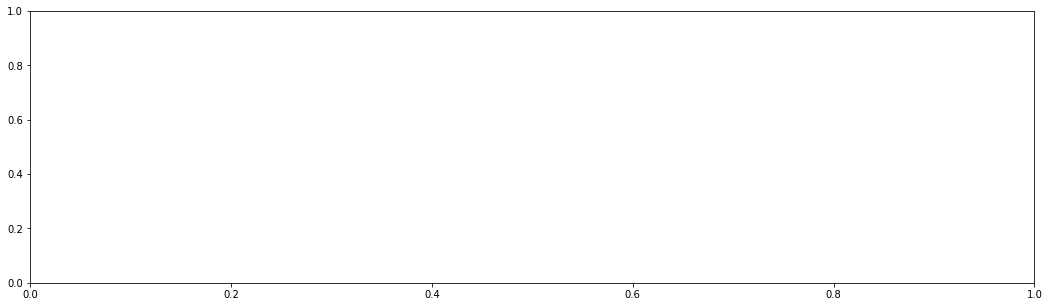

In [154]:
b = mat['FIRA'][0][2]#['task']
# a = mat['FIRA'][0][0]#['task']

fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(b[:, 11])

In [161]:
mat['FIRA'][0][2][-3][0][0][0]

array([[1229],
       [1596],
       [1768],
       [1911],
       [1953],
       [2052],
       [2124],
       [2510],
       [3663],
       [3703]], dtype=uint16)

In [188]:
mask = np.zeros((10000, 1362), dtype=bool)
for ii in range(len(mat['FIRA'][0][2])):
    aux = mat['FIRA'][0][2][ii][0][0][0]
    if len(aux) > 1:
        aux = np.array(aux[:, 0])
        mask[aux, ii] = True
#         try:
#             l.append(np.max(aux))
#         except:
#             print(aux, len(aux))

# [np.max(mat['FIRA'][0][2][ii][0][0][0]) for ii in range(len(mat['FIRA'][0][2])) if len(mat['FIRA'][0][2][ii]) > 0]

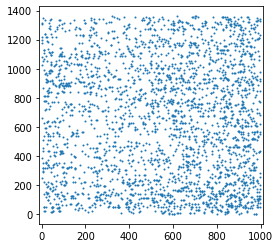

In [201]:
st = SpikeTrain(np.arange(mask.shape[0]), mask)
st = SpikeTrain(np.arange(1000), mask[:1000])
fig, ax = plt.subplots(figsize=(4, 4))
st.plot(ax=ax, ms=1)